## Image detection using YOLO algorithm or some variation or R-CNN

I'm going to attempt to implement some variation of the YOLO (You only look once) or R-CNN algorithm to detect polyps on colonoscopy footage. I'm working with pretty limited processing power so we will be using less computations than normal. This is currently running on tf1 without a gpu but I think ill have a gpu by tommorow.

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2
import sys
sys.path.insert(0, 'C:\\Users\McClain.Thiel\Documents\desktop\polyp_vis\keras-yolo2-master')
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes

%matplotlib inline
tf.__version__

Using TensorFlow backend.


'1.13.1'

In [4]:
LABELS = ['RBC']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [14]:
wt_path = 'yolo.weights'

In [6]:

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}


In [7]:

image_path = 'Labeled_original_yolo/yolo_original-PascalVOC-export/JPEGImages/'
annot_path = 'Labeled_original_yolo/yolo_original-PascalVOC-export/Annotations/'

all_imgs, seen_labels = parse_annotation(annot_path, image_path)

# add extensions to image name
for img in all_imgs:
    img['filename'] = img['filename']

In [8]:
batches = BatchGenerator(all_imgs, generator_config)

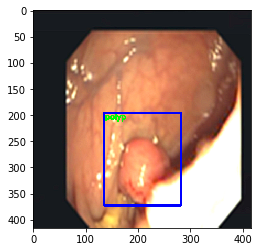

In [9]:
image = batches[0][0][0][0]
plt.imshow(image.astype('uint8'));

In [10]:
def normalize(image):
    return image/255.

In [65]:
train_valid_split = int(0.8*len(all_imgs))

train_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config)
valid_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=normalize)

In [11]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [16]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False, input_shape=(416,416,3))(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
leaky_re_lu_34 (LeakyReLU)      (None, 26, 26, 256)  0           norm_12[0][0]                    
__________________________________________________________________________________________________
conv_13 (Conv2D)                (None, 26, 26, 512)  1179648     leaky_re_lu_34[0][0]             
__________________________________________________________________________________________________
norm_13 (BatchNormalization)    (None, 26, 26, 512)  2048        conv_13[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_35 (LeakyReLU)      (None, 26, 26, 512)  0           norm_13[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 13, 13, 512)  0           leaky_re_lu_35[0][0]             
__________

In [19]:
#loading pretrained weights and applying them to the model
weight_reader = WeightReader(wt_path)
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [20]:
#randomizing the last layer
layer = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

In [21]:
#costom loss function --i do not understand

def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss


In [22]:
#implementing call backs and early stopping

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_blood.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [68]:
'''tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'blood' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'blood' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)'''

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint],#, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/100
31/31 [==============================] - ETA: 9:20 - loss: 0.721 - ETA: 7:18 - loss: 0.697 - ETA: 6:30 - loss: 0.606 - ETA: 6:00 - loss: 0.541 - ETA: 5:38 - loss: 0.500 - ETA: 5:19 - loss: 0.472 - ETA: 5:02 - loss: 0.446 - ETA: 4:47 - loss: 0.423 - ETA: 4:32 - loss: 0.402 - ETA: 4:18 - loss: 0.382 - ETA: 4:04 - loss: 0.363 - ETA: 3:51 - loss: 0.346 - ETA: 3:38 - loss: 0.331 - ETA: 3:26 - loss: 0.317 - ETA: 3:13 - loss: 0.304 - ETA: 3:00 - loss: 0.293 - ETA: 2:48 - loss: 0.282 - ETA: 2:35 - loss: 0.273 - ETA: 2:23 - loss: 0.264 - ETA: 2:11 - loss: 0.256 - ETA: 1:59 - loss: 0.249 - ETA: 1:47 - loss: 0.242 - ETA: 1:35 - loss: 0.235 - ETA: 1:23 - loss: 0.229 - ETA: 1:11 - loss: 0.224 - ETA: 59s - loss: 0.219 - ETA: 47s - loss: 0.21 - ETA: 35s - loss: 0.20 - ETA: 23s - loss: 0.20 - ETA: 11s - loss: 0.20 - 412s 13s/step - loss: 0.1974 - val_loss: 0.3845

Epoch 00001: val_loss improved from inf to 0.38446, saving model to weights_blood.h5
Epoch 2/100
31/31 [=======================

31/31 [==============================] - ETA: 5:50 - loss: 0.001 - ETA: 5:38 - loss: 0.001 - ETA: 5:25 - loss: 0.001 - ETA: 5:13 - loss: 0.001 - ETA: 5:02 - loss: 0.001 - ETA: 4:50 - loss: 0.001 - ETA: 4:39 - loss: 0.001 - ETA: 4:27 - loss: 0.001 - ETA: 4:15 - loss: 0.001 - ETA: 4:03 - loss: 0.001 - ETA: 3:52 - loss: 0.001 - ETA: 3:40 - loss: 0.001 - ETA: 3:29 - loss: 0.001 - ETA: 3:17 - loss: 0.001 - ETA: 3:05 - loss: 0.001 - ETA: 2:54 - loss: 0.001 - ETA: 2:42 - loss: 0.001 - ETA: 2:30 - loss: 0.001 - ETA: 2:19 - loss: 0.001 - ETA: 2:08 - loss: 0.001 - ETA: 1:56 - loss: 0.001 - ETA: 1:44 - loss: 0.001 - ETA: 1:33 - loss: 0.001 - ETA: 1:21 - loss: 0.001 - ETA: 1:09 - loss: 0.001 - ETA: 58s - loss: 0.001 - ETA: 46s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 11s - loss: 0.00 - 406s 13s/step - loss: 0.0010 - val_loss: 0.0013

Epoch 00009: val_loss improved from 0.00185 to 0.00132, saving model to weights_blood.h5
Epoch 10/100
31/31 [==============================

In [98]:
def clean_input(image):
    img = cv2.resize(image, (416, 416))/255.0
    return np.expand_dims(img[:,:,::-1], 0)

def predict_box(input_img):
    netout = model.predict([input_img, np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.9,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    return boxes

def draw_pred(image):
    img = clean_input(image)
    boxes = predict_box(img)
    image = draw_boxes(image/255, boxes, labels=LABELS)
    plt.imshow(image)
    #plt.figure(figsize=(10,10))
    return plt.imshow(image)
    

In [81]:
def loop_images(x):
    return batches[0][0][0][x]
def wrapper(num):
    return draw_pred(loop_images(num))

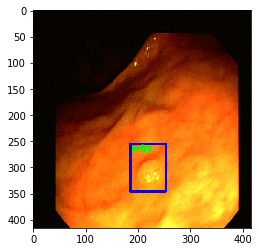

<Figure size 720x720 with 0 Axes>

In [83]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(wrapper, num= widgets.IntSlider(min=1,max=600,step=1,value=1));
#file crawing and stuff with interact

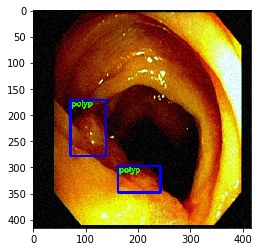

In [108]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
ims = []
for x in range(15):
    im = wrapper(x)
    plt.savefig('preds/img' + x +'png')
    ims.append(im)
    


In [94]:
import ffmpeg